# Copulas Application: Pairs Trading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

## Select pairs

In [4]:
# The original data
prices = pd.read_csv('../data/vbr18_21.csv', index_col=0)
prices = prices.dropna(axis=1)
returns = np.log(prices).diff().dropna()

In [5]:
form_start = '2018-11-20'
form_end = '2020-05-19'
trade_start = '2021-05-20'
trade_end = '2021-11-19'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [6]:
# Calculate Kendall's tau for each pair of stocks
results = pd.DataFrame(columns=['tau'])

for s1 in returns_form.columns:
    for s2 in returns_form.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):
            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]

In [7]:
results.to_csv('pairs_tau.csv')

In [8]:
results.sort_values(by='tau')

,tau
WTRG-SWN,-0.054499
FLO-SWN,-0.050804
OVV-FLO,-0.045919
FLO-AR,-0.045274
BGS-WK,-0.041691
...,...
HOMB-CATY,0.725432
CFR-ASB,0.729228
CFR-BOKF,0.731751
MTG-RDN,0.738985


In [9]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

selected_stocks = []
selected_pairs = []

for pair in results.sort_values(by='tau', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        selected_pairs.append(pair)
    
    if len(selected_pairs) == 25:
        break

In [10]:
selected_pairs

['CENTA-CENT',
 'MTG-RDN',
 'CFR-BOKF',
 'HOMB-CATY',
 'CMA-ZION',
 'EWBC-ASB',
 'UMBF-FULT',
 'TDS-USM',
 'KIM-BRX',
 'PACW-FNB',
 'NBTB-STBA',
 'VOYA-LNC',
 'VLY-HOPE',
 'ONB-FFBC',
 'COLB-FCF',
 'ROIC-AKR',
 'UBSI-TRMK',
 'FRME-HTLF',
 'WAL-UMPQ',
 'STL-HWC',
 'FR-EGP',
 'GBCI-FIBK',
 'PBCT-WBS',
 'AWR-CWT',
 'AUB-TOWN']

### The Marginals

In [11]:
marginals_df = pd.DataFrame(index=selected_stocks, columns=['Distribution', 'AIC', 'BIC', 'KS_pvalue'])

for stock in selected_stocks:
    data = returns_form[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        if aic < best_aic:
            best_dist = name
            best_aic = aic
            best_bic = len(params) * np.log(len(data)) - 2 * log_like
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
    marginals_df.loc[stock] = [best_dist, best_aic, best_bic, ks_pval]

In [12]:
marginals_df.head(10)

,Distribution,AIC,BIC,KS_pvalue
CENTA,Student's t,-1766.721394,-1754.948627,0.501764
CENT,Student's t,-1776.277334,-1764.504567,0.788573
MTG,Student's t,-1705.88267,-1694.109902,0.648663
RDN,Student's t,-1721.424509,-1709.651741,0.739781
CFR,Student's t,-1733.045019,-1721.272252,0.864011
BOKF,Student's t,-1749.361441,-1737.588673,0.871464
HOMB,Student's t,-1659.902646,-1648.129878,0.957393
CATY,Student's t,-1783.08619,-1771.313422,0.990013
CMA,Student's t,-1650.420255,-1638.647488,0.421582
ZION,Student's t,-1799.031782,-1787.259015,0.494674


In [13]:
marginals_df['Distribution'].unique()

array(["Student's t"], dtype=object)

In [ ]:
marginals_df[marginals_df['KS_pvalue'] < 0.05]

### The copulas

In [27]:
from my_copulas import *
import ndtest # bivariate Kolmogorov-Smirnov

In [35]:
copulas_df = pd.DataFrame(index=selected_pairs, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    # fit marginals
    params_s1 = stats.t.fit(returns_form[s1])
    dist_s1 = stats.t(*params_s1)
    params_s2 = stats.t.fit(returns_form[s2])
    dist_s2 = stats.t(*params_s2)
    # apply probability integral transform
    u = dist_s1.cdf(returns_form[s1])
    v = dist_s2.cdf(returns_form[s2])
    
    # print(f"shape u={u.shape}, v={v.shape}")
    best_aic = np.inf
    
    for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(),  JoeCopula()]:
        copula.fit(u,v)
        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_bic = copula.num_params * np.log(len(u)) - 2 * L
            best_copula = copula.name
            
            # calculate KS-pvalue
            smp = copula.sample(size=len(u)) # generate sample from fit copula
            s_u = smp[:,0]
            s_v = smp[:,1]
            ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
            
            if isinstance(copula, ArchimedeanCopula):
                best_param = copula.alpha
            else:
                best_param = copula.rho
            
    copulas_df.loc[pair] = [best_copula, best_param, best_aic, best_bic, ks_pval]

/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


## Baseline

In [31]:
import yfinance as yf
vbr_price = yf.download('VBR', start=trade_start, end=trade_end, proxy="http://10.0.5.8:30890")
vbr_price = vbr_price['Adj Close']
vbr_ret = vbr_price.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


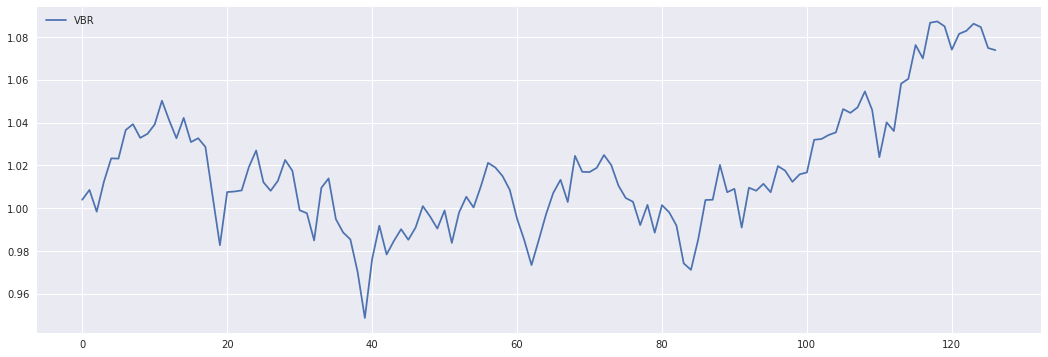

In [32]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(vbr_ret + 1), label='VBR')
plt.legend()

## Trading strategy

In [30]:
algo_returns = {}
cl = 0.99 # confidence level

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)

    # fit marginals
    params_s1 = stats.t.fit(returns_form[s1])
    dist_s1 = stats.t(*params_s1)
    params_s2 = stats.t.fit(returns_form[s2])
    dist_s2 = stats.t(*params_s2)

    # transform marginals
    u = dist_s1.cdf(returns_form[s1])
    v = dist_s2.cdf(returns_form[s2])
        
    # fit copula
    best_aic = np.inf
    best_copula = None

    copulas = [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]
    for copula in copulas:
        copula.fit(u,v)
        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_copula = copula
            
    # calculate conditional probabilities
    prob_s1 = []
    prob_s2 = []

    for u,v in zip(dist_s1.cdf(returns_trade[s1]), dist_s2.cdf(returns_trade[s2])):
        prob_s1.append(best_copula.cdf_u_given_v(u,v))
        prob_s2.append(best_copula.cdf_v_given_u(u,v))
        
    probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=returns_trade.index, columns=[s1, s2])
    
    # calculate positions
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False

    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > 0.5) or (probs_trade.loc[t][s2] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < 0.5) or (probs_trade.loc[t][s2] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]
                
    # calculate returns
    algo_ret = (returns_trade * positions.shift()).sum(axis=1)
    algo_returns[pair] = algo_ret

/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()
/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()
/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()
/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()
/srv/Codes/jack/paper_impls/copulas/my_copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


In [33]:
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

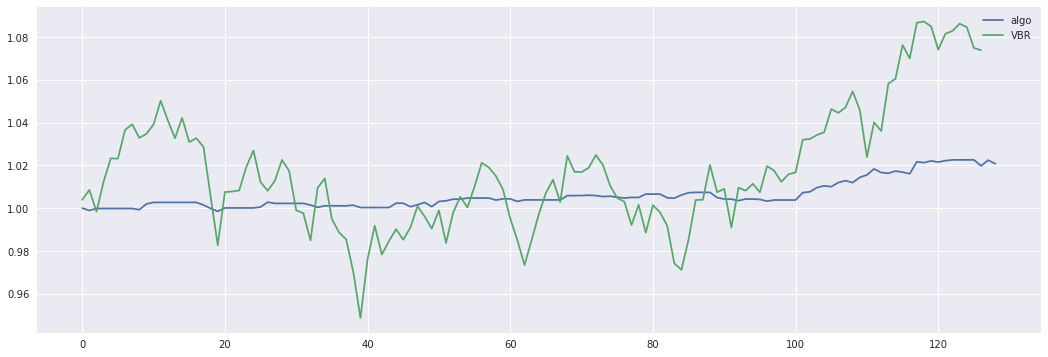

In [34]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(vbr_ret + 1), label='VBR')
plt.legend()

## Trading Analysis

## Resources

* https://hudsonthames.org/copula-for-pairs-trading-introduction/
* https://www.linkedin.com/pulse/copula-based-strategies-quantitative-trading-investing-/
* https://www.quantconnect.com/research/15298/pairs-trading-copula-vs-cointegration/p1
* https://www.researchgate.net/publication/318054326_Trading_strategies_with_copulas
* https://hudsonthames.org/copula-for-pairs-trading-introduction/
* https://hudsonthames.org/copula-for-pairs-trading-overview-of-common-strategies/

Pair selection:

* https://hudsonthames.org/employing-machine-learning-for-trading-pairs-selection/